In [1]:
library(Seurat)
library(ggplot2)

Attaching SeuratObject

Attaching sp



In [3]:
fn = function(p, no.legend=T) {
    lx = unlist(lapply(p$patches$plots, function(x) {ggplot_build(x)$layout$panel_scales_x[[1]]$range$range}))
    ly = unlist(lapply(p$patches$plots, function(x) {ggplot_build(x)$layout$panel_scales_y[[1]]$range$range}))
    p = p & theme(panel.grid=element_line(colour="grey", size=0.5)) & xlim(min(lx), max(lx)) & ylim(min(ly), max(ly)) 
    if (no.legend) p = p & NoLegend()
    return(p)
}

In [4]:
path2root = "/work/magroup/tianming/Researches/sc-hic/data2/final"
print(path2root)

[1] "/work/magroup/tianming/Researches/sc-hic/data2/final"


# 1. Load GAGE-seq data

In [5]:
data <- Read10X(data.dir = file.path(path2root, "results", "RNA_mBC_complete_mm10_filtered_10x"))
obj <- CreateSeuratObject(counts = data, project = "mBC", min.cells = 10)
df_meta = read.csv(
    file.path(path2root, "results", "meta_mBC_complete_mm10_filtered.csv"), header = TRUE,
    row.name = 1, sep = ",",
)
stopifnot(all.equal(colnames(obj), rownames(df_meta)))
obj = AddMetaData(obj, df_meta)
obj[['dataset']] = 'GAGE-seq'

path2file = file.path(path2root, "results", "meta-Seurat_mBC_complete_mm10_filtered.csv")
df = read.csv(path2file, row.names=1)
obj = obj[,rownames(df)]
obj$seurat_clusters = df
Idents(obj) = obj$seurat_clusters
levels(obj) = c(
    "L2 IT RvPP", "L2/3 IT RSP", "L2/3 IT CTX a", "L2/3 IT CTX b", "L2/3 IT CTX c",
    "L4 IT CTX", "L4/5 IT CTX", "L5 IT RSP", "L5 IT CTX", "L6 IT CTX",
    "L5 PT CTX", "L6 CT CTX a", "L6 CT CTX b", "L5/6 NP CTX", "L6b CTX",
    "Pvalb a", "Pvalb b", "Sst a", "Sst b", "Vip", "Sncg", "Lamp5", "Meis2",
    "Astro", "OPC", "ODC", "VLMC", "Micro", "Unk")

obj.gage = obj
obj

An object of class Seurat 
17019 features across 3296 samples within 1 assay 
Active assay: RNA (17019 features, 0 variable features)

In [6]:
obj.gage <- NormalizeData(obj.gage, verbose=F)
obj.gage <- FindVariableFeatures(obj.gage, verbose=F)
obj.gage <- ScaleData(obj.gage, features=rownames(obj.gage), verbose=F)
obj.gage <- RunPCA(obj.gage, verbose=F, npcs = 40)

# 2. Load Paired-Tag data

In [7]:
path2dir = '/work/magroup/tianming/Researches/sc-hic/data/ref_datasets/Paired-Tag'
data <- Read10X(data.dir=file.path(path2dir, '01.Paired-Tag_seq_RNA_filtered_matrix'))
obj <- CreateSeuratObject(counts = data, project = "Paired-Tag", min.cells = 10)

df = read.csv(file.path(path2dir, 'Paired-seq-Table 1.csv'), header = TRUE, row.name = 1)
df$Target = "RNA"
df_meta = do.call(rbind, list(
    read.csv(file.path(path2dir, 'Paired-Tag_H3K27ac-Table 1.csv'), header = TRUE, row.name = 1),
    read.csv(file.path(path2dir, 'Paired-Tag_H3K27me3-Table 1.csv'), header = TRUE, row.name = 1),
    read.csv(file.path(path2dir, 'Paired-Tag_H3K4me1-Table 1.csv'), header = TRUE, row.name = 1),
    read.csv(file.path(path2dir, 'Paired-Tag_H3K4me3-Table 1.csv'), header = TRUE, row.name = 1),
    read.csv(file.path(path2dir, 'Paired-Tag_H3K9me3-Table 1.csv'), header = TRUE, row.name = 1),
    df
))
df_meta$dataset = 'Paired-Tag'
obj = AddMetaData(obj, df_meta)

obj.pairedtag = obj

# 3. Integration

In [8]:
path2figdir = file.path(path2root, 'figures-integrate-mBC-PairedTag')
print(path2figdir)

[1] "/work/magroup/tianming/Researches/sc-hic/data2/final/figures-integrate-mBC-PairedTag"


In [9]:
print(Sys.time())
obj.list <- list(
    subset(obj.gage, subset=seurat_clusters%in%c(
        "L2/3 IT CTX a", "L2/3 IT CTX b", "L2/3 IT CTX c", "L4 IT CTX", "L4/5 IT CTX", "L5 IT CTX", "L6 IT CTX", 
        "L5 PT CTX", "L6 CT CTX a", "L6 CT CTX b", "L5/6 NP CTX", "L6b CTX",
        "Pvalb a", "Pvalb b", "Sst a", "Sst b", "Vip", "Sncg", "Lamp5", "Meis2",
        "Astro", "OPC", "ODC", "VLMC", "Micro"
    )),
    subset(obj.pairedtag, subset=Annotation%in%c(
        'BR_InNeu_CGE', 'BR_InNeu_Pvalb', 'BR_InNeu_Sst',
        'BR_NonNeu_Astro_Myoc', 'BR_NonNeu_Astro_Nnat', 'BR_NonNeu_Microglia',
        'BR_NonNeu_Oligo_MFOL', 'BR_NonNeu_Oligo_MOL', 'BR_NonNeu_OPC',
        'FC_ExNeu_L23', 'FC_ExNeu_L4', 'FC_ExNeu_L5', 'FC_ExNeu_L6', 
        'FC_ExNeu_CT', 'FC_ExNeu_NP', 'FC_ExNeu_PT'
    ) & Target=="RNA")
)
print(Sys.time())
print(obj.list)
features <- SelectIntegrationFeatures(object.list = obj.list, verbose=F)
print(Sys.time())
anchors <- FindIntegrationAnchors(object.list = obj.list, anchor.features = features, verbose=F)
print(Sys.time())
obj.int.pairedtag <- IntegrateData(anchorset = anchors, verbose=F)
print(Sys.time())

[1] "2023-12-01 15:12:46 EST"
[1] "2023-12-01 15:12:48 EST"
[[1]]
An object of class Seurat 
17019 features across 2865 samples within 1 assay 
Active assay: RNA (17019 features, 2000 variable features)
 1 dimensional reduction calculated: pca

[[2]]
An object of class Seurat 
46012 features across 9568 samples within 1 assay 
Active assay: RNA (46012 features, 0 variable features)

[1] "2023-12-01 15:12:55 EST"
[1] "2023-12-01 15:13:42 EST"
[1] "2023-12-01 15:13:59 EST"


In [10]:
obj = obj.int.pairedtag
num_pcs = 20
obj <- ScaleData(obj, verbose=F)
obj <- RunPCA(obj, npcs = num_pcs, verbose=F)
obj <- RunUMAP(obj, min.dist=0, n.neighbors=20, dims = 1:num_pcs, verbose=F)
obj.int.pairedtag = obj

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


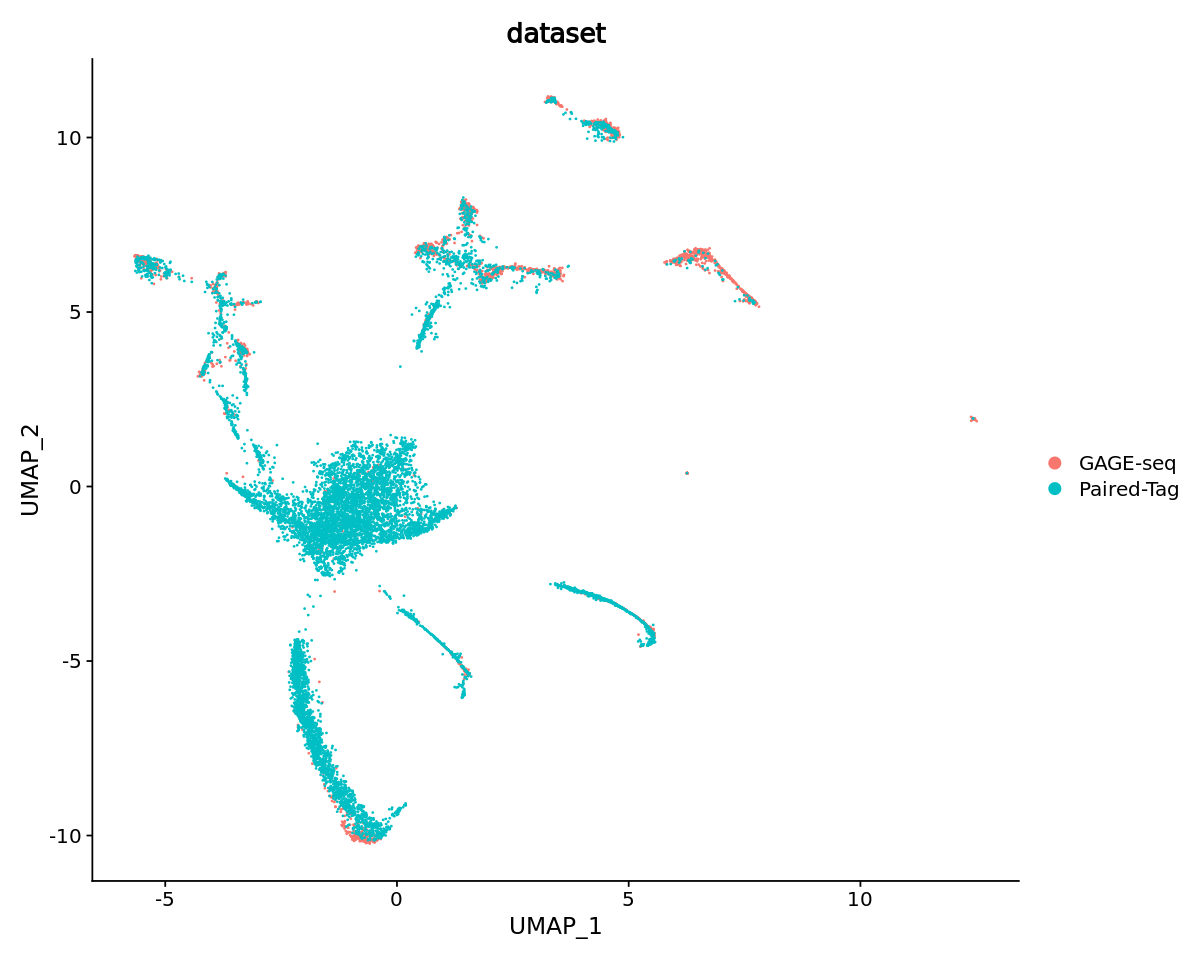

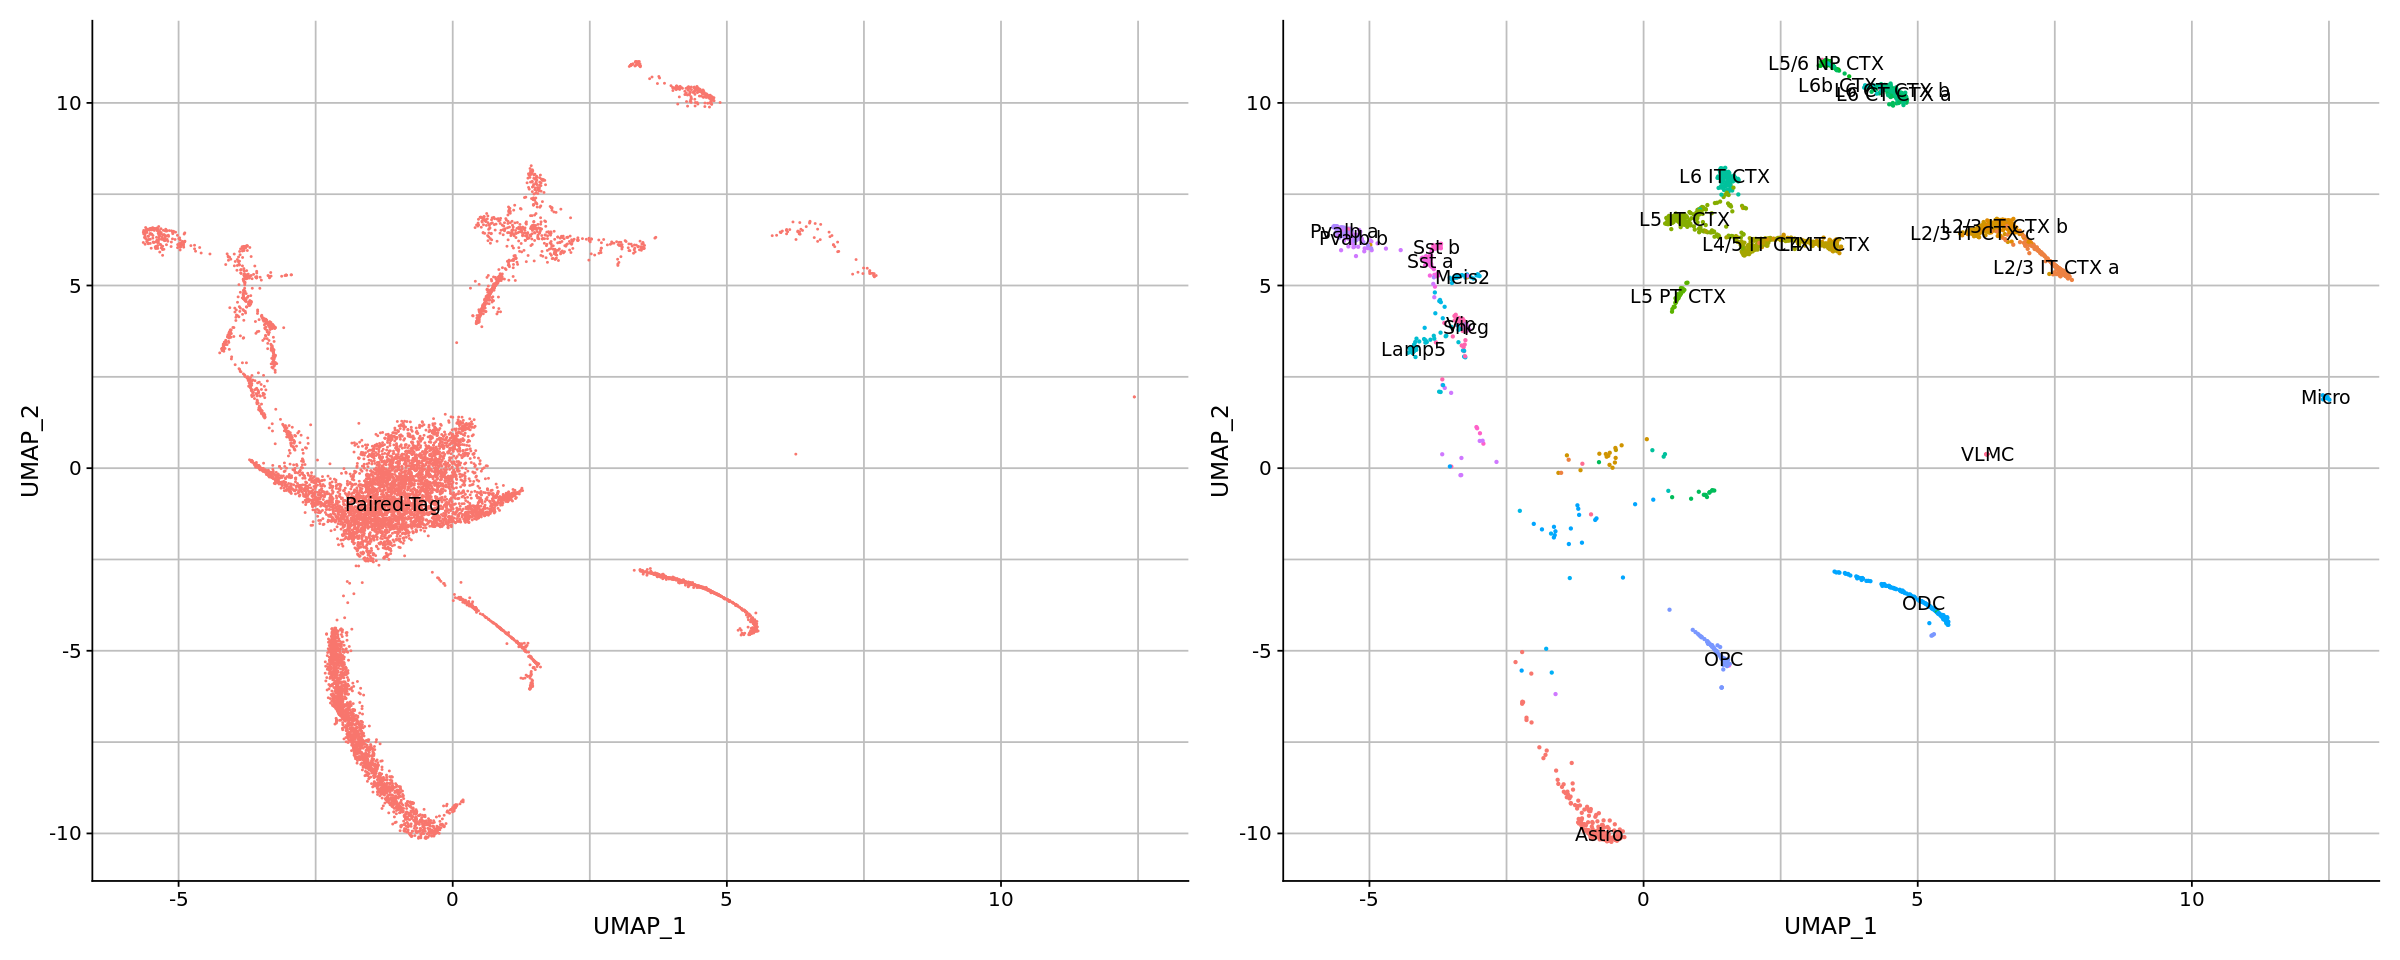

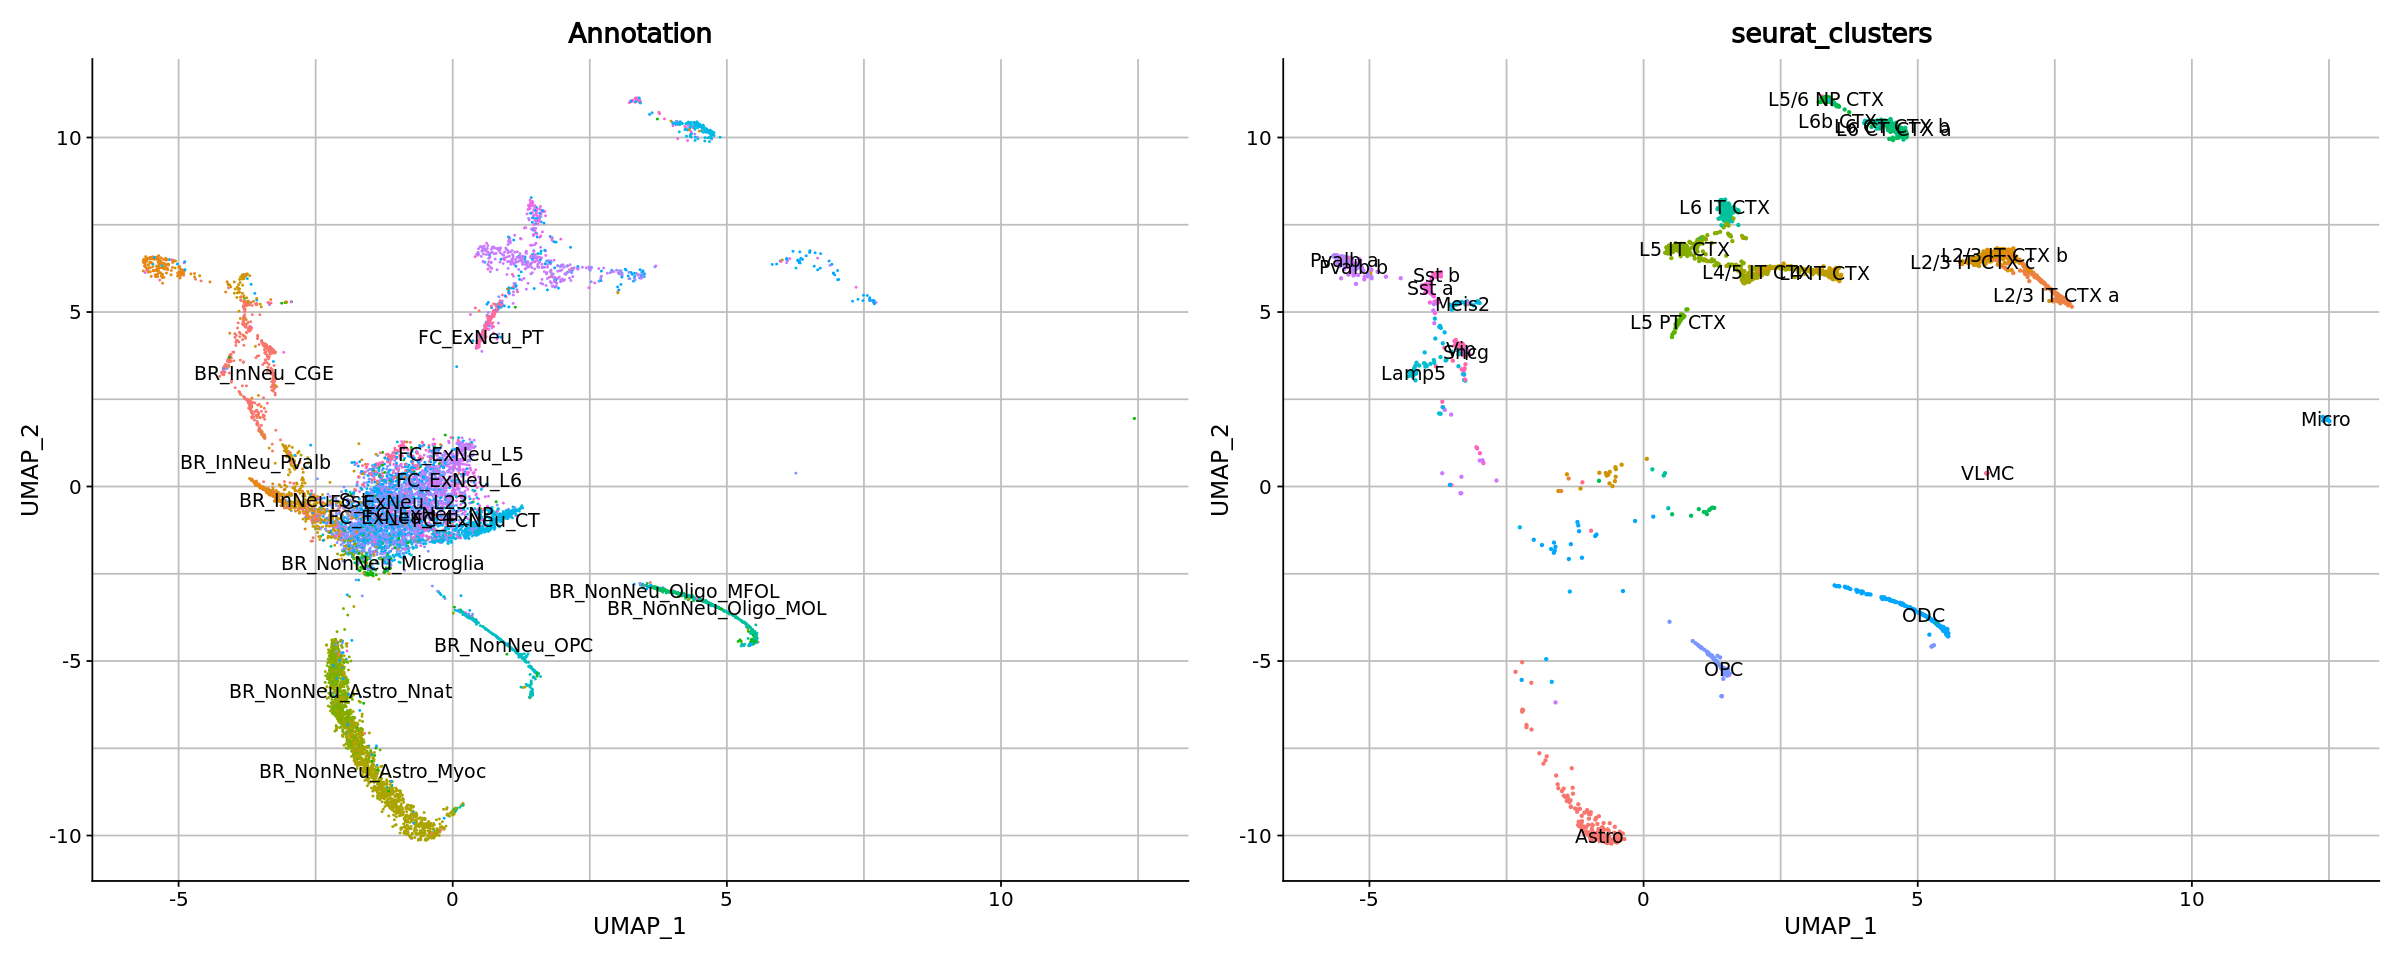

In [11]:
obj = obj.int.pairedtag

saved <- options(repr.plot.width=10, repr.plot.height=8)
DimPlot(obj, group.by="dataset")
options(saved)

saved <- options(repr.plot.width=20, repr.plot.height=8)
fn(DimPlot(subset(x=obj, subset=dataset == "Paired-Tag"), label=T, repel=F)+
   DimPlot(subset(x=obj, subset=dataset == "GAGE-seq"), label=T, repel=F))
fn(DimPlot(subset(x=obj, subset=dataset == "Paired-Tag"), group.by="Annotation", label=T, repel=F)+
   DimPlot(subset(x=obj, subset=dataset == "GAGE-seq"), group.by='seurat_clusters', label=T, repel=F))
options(saved)

In [12]:
obj = obj.int.pairedtag
path2file = file.path(path2root, "results_mBC_integration_PairedTag", "PCA-Seurat-test.csv")
write.csv(data.frame(obj[["pca"]]@cell.embeddings), path2file)
path2file = file.path(path2root, "results_mBC_integration_PairedTag", "UMAP-Seurat-test.csv")
write.csv(data.frame(obj[["umap"]]@cell.embeddings), path2file)